In [3]:
import os
from glob import glob
import librosa
import pandas as pd
import numpy as np
import csv
from spafe.features.gfcc import gfcc
from scipy.io.wavfile import read
from spafe.utils import vis
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [8]:
file_name_2 = f'./donateacry_corpus_cleaned_and_updated_data/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp.wav'
fs, sig = read(file_name_2)
gfccs = gfcc(sig, fs=fs, num_ceps=13)
print(gfccs.shape)

(698, 13)


In [21]:
header = 'filename'
for i in range(1, 21):
    header += f' gfcc{i}'
header += ' label'
header = header.split()

In [22]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
categories = 'belly_pain burping discomfort hungry tired'.split()
for c in categories:
        for filename in os.listdir(f'./donateacry_corpus_cleaned_and_updated_data/{c}'):
            file_name = f'./donateacry_corpus_cleaned_and_updated_data/{c}/{filename}'
            y, sr = librosa.load(file_name, duration=6)
            fs, sig = read(file_name)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            onset_env = librosa.onset.onset_strength(y=y, sr=sr)
            gfccs = gfcc(sig, fs=fs, num_ceps=20)
            to_append = f'{filename} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(onset_env)}'
            to_append = f'{filename}'
            gfccs = np.transpose(gfccs)
            for e in gfccs:
                to_append += f' {np.mean(e)}'
            to_append += f' {c}'
            file = open('data.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())


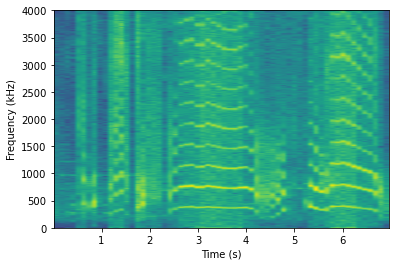

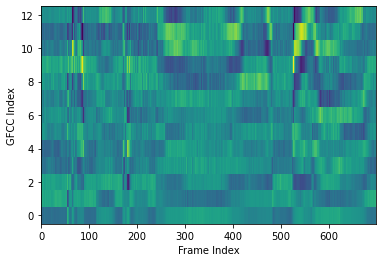

In [11]:
vis.spectogram(sig, fs)
vis.visualize_features(gfccs, 'GFCC Index', 'Frame Index')

In [23]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('SVM', SVC()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))

In [24]:
features = ['data.csv']
for feature in features:
    print(feature)
    
    df = pd.read_csv(feature)
    df.drop('filename', axis=1, inplace=True)
    
    
    #taking equal audios of all classes, comment if not required
    #-------------code-----------
    
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)
    
    #standard scaling the features, comment if not required
    scl = StandardScaler()
    X_train = scl.fit_transform(X_train)
    X_test = scl.transform(X_test) 
    
    #creating array of sample_weight to be passed in fit method for imbalanced dataset, comment if not required
    wt = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    classes = np.unique(y_train)
    wtd = {}
    for i in range(len(wt)):
        wtd[classes[i]] = wt[i]
    swt = [wtd[_] for _ in y_train]
    
    
    
    for name, model in models:
        if(name != 'KNN'):
            model.fit(X_train, y_train, sample_weight=swt)
        else:
            model.fit(X_train, y_train)
            
        y_pred = model.predict(X_test)
    
        # Summary of the predictions made by the classifier
        print(name)
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        




data.csv


c:\users\sarth\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=['belly_pain' 'burping' 'discomfort' 'hungry' 'tired'], y=['hungry' 'hungry' 'hungry' 'hungry' 'hungry' 'hungry' 'hungry' 'hungry'
 'hungry' 'hungry' 'hungry' 'hungry' 'hungry' 'burping' 'hungry' 'hungry'
 'hungry' 'hungry' 'hungry' 'hungry' 'hungry' 'hungry' 'hungry' 'hungry'
 'hungry' 'burping' 'hungry' 'hungry' 'discomfort' 'hungry' 'hungry'
 'discomfort' 'hungry' 'hungry' 'discomfort' 'hungry' 'discomfort'
 'hungry' 'hungry' 'hungry' 'discomfort' 'burping' 'hungry' 'hungry'
 'tired' 'hungry' 'hungry' 'hungry' 'hungry' 'hungry' 'hungry' 'hungry'
 'belly_pain' 'hungry' 'hungry' 'hungry' 'hungry' 'hungry' 'hungry'
 'hungry' 'hungry' 'hungry' 'hungry' 'belly_pain' 'hungry' 'hungry'
 'hungry' 'hungry' 'belly_pain' 'hungry' 'belly_pain' 'hungry'
 'discomfort' 'hungry' 'hungry' 'hungry' 'hungry' 'hungry' 'hungry'
 'hungry' 'hungry' 'hungry' 'discomfort' 'h

LR
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         3
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         5
      hungry       0.86      0.23      0.37        77
       tired       0.04      0.20      0.07         5

    accuracy                           0.21        92
   macro avg       0.18      0.09      0.09        92
weighted avg       0.72      0.21      0.31        92

[[ 0  2  0  0  1]
 [ 0  0  1  0  1]
 [ 0  1  0  1  3]
 [21  6 14 18 18]
 [ 1  0  1  2  1]]
SVM
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         3
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         5
      hungry       0.86      0.82      0.84        77
       tired       0.00      0.00      0.00         5

    accuracy                           0.68        92
   macro avg       0.17      0.16

c:\users\sarth\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
